# Pyomo.DAE Example: Temperature Control Lab

This page is [adapted from our process control class](https://github.com/ndcbe/controls/blob/main/notebooks/06.02-Simulation-and-Open-Loop-Optimal-Control.ipynb) at Notre Dame; it was developed by Prof. Jeff Kantor.

## Learning Objectives

* Review syntax for Pyomo.DAE
* See how an optimization problem with zero degrees of freedom is a simulation problem
* Pratice using [units](https://pyomo.readthedocs.io/en/stable/advanced_topics/units_container.html) feature in Pyomo

## Install Packages and Load Modules

In [1]:
# Install Pyomo and solvers for Google Colab
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()

# import Pyomo library
import pyomo.environ as pyo
import pyomo.dae as dae
import matplotlib.pyplot as plt
from pyomo.environ import units

## Temperature Control Lab Dynamic Model

The [temperature control lab](http://apmonitor.com/pdc/index.php/Main/ArduinoTemperatureControl) is an Arduino-based hands-on experiment for teaching dynamic modeling and process control developed by Prof. John Hedengren. At Notre Dame, we restructured our core [undergraduate process control class](https://ndcbe.github.io/controls/Readme.html) around six hands-on laboratory assignments with the TCLab.

The TCLab board contains two heater plus temperature sensor assemblies. Using Python (or MATLAB), students can independently maninputate the electrical power to the heaters and measure the temperatures.

For simplicity, we will develop a mathemical single heater and temperature sensor assembly. However, this workshop example also supports modeling both assemblies.

![TCLab schematic](../../media/tclab_schematic2.jpg)

We will define two **states**:
* $T_{H,1}$ is the temperature of the heater/fin assembly (°C)
* $T_{S,1}$ is the temperature of the sensor (°C)

Assumptions:
* The two bodies are uniform temperature, i.e., we are neglecting any temperature gradients in the fin.
* The sensor exchanges heat only with the heater, and heat transfer to the surroundings is dominated by the heat sink attached to the heater.]
* Heat capacities $C_p$ are constant.
* Radiative heat transfer is negligible.

We define the **manipulated variable**:
* $u_1$ is the power sent to the heater (% of max)

This motivates the following model:

$$
\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + \alpha P_1u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1}) 
\end{align}
$$

The model has the following **unknown parameters**:
* $C^H_p$ is the heat capacity of the heater/fin assembly (J / °C)
* $C^S_p$ is the heat capacity of the sensor (J / °C)
* $U_a$ is the heat transfer coefficient from the heater/fin to ambient (W / °C)
* $U_b$ is the heat transfer coefficient from the heater/fin to the sensor (W / °C)

And the following **known parameters**:
* $\alpha P_1$ are constants for the TCLab (W / %)
* $T_{amb}$ is the ambient temperature (°C)

Let's start by defining some model coefficients:

In [2]:
# parameters
alpha = 0.00016 * units.W  # watts / (units P * percent U1)
P = 200  # P units
Ua = 0.050 * units.W / units.kelvin  # heat transfer coefficient from heater to environment
CpH = 2.2 * units.J / units.kelvin # heat capacity of the heater (J/deg C)
CpS = 1.9 * units.J / units.kelvin # heat capacity of the sensor (J/deg C)
Ub = 0.021 * units.W / units.kelvin  # heat transfer coefficient from heater to sensor
Tamb_C = 21.0  # ambient temperature in deg C
Tamb = units.convert_temp_C_to_K(Tamb_C) * units.kelvin  # ambient temperature

## Simulate a Step Test (ramp)

We will start by **simulating** our TCLab model. In other words, we will solve the following optimization problem with zero degrees of freedom:

\begin{align*}
\max{}~~ & 0 \\
\mathrm{s.t.}~~ & C_p^H \frac{dT_H}{dt} = U_a (T_{amb} - T_H) + U_b (T_S - T_H) + \alpha P u(t) \\
 & C_p^S \frac{dT_S}{dt} = - U_b (T_S - T_H) \\
 & T_H(t_0) = T_{amb} \\
 & T_S(t_0) = T_{amb} \\
 & u(t) = u_{ramp} = 50\%, \quad \forall t \in [t_0, t_f]
\end{align*}

Here "s.t." means "subject to", i.e., the constraints.

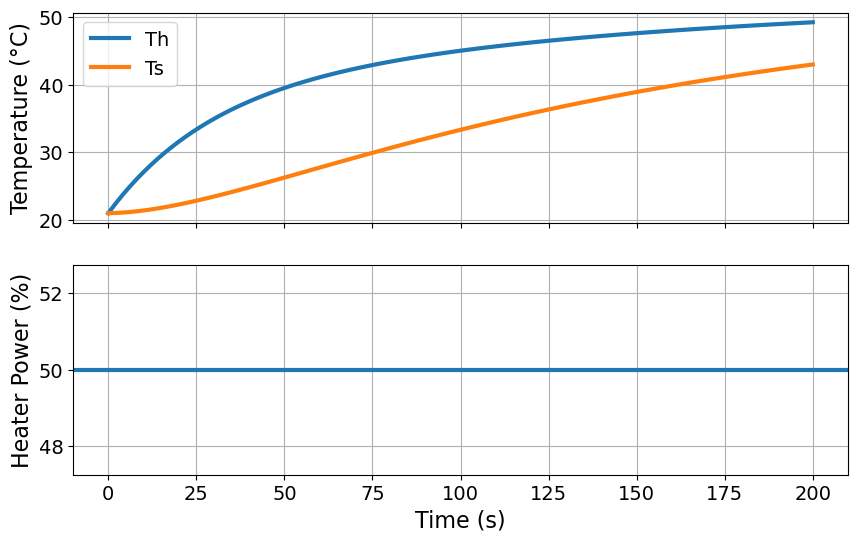

In [3]:
# final time [seconds]
tf = 200
# Why not units here? See
# https://github.com/Pyomo/pyomo/issues/1790

# control input [%]
u = 50.0

# Create a Pyomo model
m = pyo.ConcreteModel('TCLab Heater/Sensor')

# Define time domain
m.t = dae.ContinuousSet(bounds=(0, tf))

# Define the state variables as a function of time
m.Th = pyo.Var(m.t, units=units.kelvin)
m.Ts = pyo.Var(m.t, units=units.kelvin)

# Define the derivatives of the state variables
m.dTh = dae.DerivativeVar(m.Th)
m.dTs = dae.DerivativeVar(m.Ts)


# Define the first differential equation
def heater1(m, t):
    return (
        CpH * m.dTh[t]
        == Ua * (Tamb - m.Th[t]) + Ub * (m.Ts[t] - m.Th[t]) + alpha * P * u
    )


m.heater1_con = pyo.Constraint(m.t, rule=heater1)


# Define the second differential equation
def sensor1(m, t):
    return CpS * m.dTs[t] == Ub * (m.Th[t] - m.Ts[t])


m.sensor1_con = pyo.Constraint(m.t, rule=sensor1)

# Set the initial conditions
m.Th[0].fix(Tamb)
m.Ts[0].fix(Tamb)

# Apply a finite difference formula to numerically integrate the differential equations
pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=100, wrt=m.t)

# Call our nonlinear optimization/equation solver, Ipopt
pyo.SolverFactory('ipopt').solve(m)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot 1: Temperature
ax[0].plot(m.t, [units.convert_temp_K_to_C(m.Th[t]()) for t in m.t], label="Th")
ax[0].plot(m.t, [units.convert_temp_K_to_C(m.Ts[t]()) for t in m.t], label="Ts")
ax[0].legend()
ax[0].set_ylabel("Temperature (°C)")
ax[0].grid()

# Plot 2: Heater Power
ax[1].axhline(u, label="Power")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Heater Power (%)")
ax[1].grid()
plt.show()

The code below to access and print results from the Pyomo model:


In [4]:
for i, t in enumerate(m.t):
    # Only print every 10 timesteps
    if i % 10 == 0:
        print(
            "Th=",
            round(pyo.value(m.Th[t]), 2),
            "°K and Ts=",
            round(pyo.value(m.Ts[t]), 2),
            "°K at time",
            round(t, 2),
            "seconds.",
        )

Th= 294.15 °K and Ts= 294.15 °K at time 0 seconds.
Th= 304.71 °K and Ts= 295.43 °K at time 20.0 seconds.
Th= 310.66 °K and Ts= 297.97 °K at time 40.0 seconds.
Th= 314.23 °K and Ts= 300.88 °K at time 60.0 seconds.
Th= 316.54 °K and Ts= 303.78 °K at time 80.0 seconds.
Th= 318.16 °K and Ts= 306.47 °K at time 100.0 seconds.
Th= 319.37 °K and Ts= 308.91 °K at time 120.0 seconds.
Th= 320.33 °K and Ts= 311.07 °K at time 140.0 seconds.
Th= 321.12 °K and Ts= 312.98 °K at time 160.0 seconds.
Th= 321.79 °K and Ts= 314.66 °K at time 180.0 seconds.
Th= 322.36 °K and Ts= 316.12 °K at time 200 seconds.


Uncomment and run the code below to see the details of the Pyomo model:

In [5]:
# m.pprint()

## Activity: Optimization by Trial-and-Error

Modify the code above to find the value for `u` that causes `Th` to reach 60 °C at the final time. In others words, we are using trial and error to solve the following optimization problem:

\begin{align*}
\min_{u_{ramp}} ~~ & ||~ T_{H}(t_f) - 60 ~||^2 \\
\mathrm{s.t.}~~ & C_p^H \frac{dT_H}{dt} = U_a (T_{amb} - T_H) + U_b (T_S - T_H) + \alpha P u(t) \\
 & C_p^S \frac{dT_S}{dt} = - U_b (T_S - T_H) \\
 & T_H(t_0) = T_{amb} \\
 & T_S(t_0) = T_{amb} \\
 & u(t) = u_{ramp}, \quad \forall t \in [t_0, t_f]
\end{align*}


## Feedforward Optimal Control

An optimal control policy minimizes the differences

$$
\begin{align*}
\min_{u} \int_{t_0}^{t_f} \|~SP(t) - T_H(t)~\|^2\,dt \\
\end{align*}
$$

subject to constraints

$$
\begin{align*}
C_p^H \frac{dT_H}{dt} & = U_a (T_{amb} - T_H) + U_c (T_S - T_H) + \alpha P u(t)\\
C_p^S \frac{dT_S}{dt} & = - U_b (T_S - T_H)  \\
\\
\text{control limits}\qquad0 \leq u(t) & \leq 100.0
\\
\text{initial condition}\qquad T_H(t_0) & = T_{amb} \\
\text{initial condition}\qquad T_S(t_0) & = T_{amb}
\end{align*}
$$

This is different than our example above because we allow $u$ to have a unique value for each timestep.

Note that `pyomo.dae` has an `Integral` object to help with these situations.

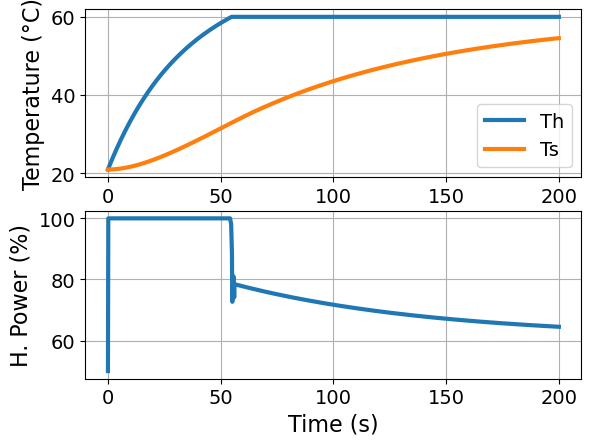

In [6]:
# Set point, deg C
SP = units.convert_temp_C_to_K(60.0) * units.kelvin

# Create a Pyomo model
m = pyo.ConcreteModel('TCLab Heater/Sensor')

# Define time domain
m.t = dae.ContinuousSet(bounds=(0, tf))

# Define the state variables as a function of time
m.Th = pyo.Var(m.t, units=units.kelvin)
m.Ts = pyo.Var(m.t, units=units.kelvin)

# Define the derivatives of the state variables
m.dTh = dae.DerivativeVar(m.Th)
m.dTs = dae.DerivativeVar(m.Ts)

# Define the control variable (heater power) as a function of time
m.u = pyo.Var(m.t, bounds=(0, 100))


# Define the integral of the squared error
@m.Integral(m.t)
def ise(m, t):
    return (SP - m.Th[t]) ** 2


# Define the first differential equation
# Notice we are defining the equation using the decorator syntax
@m.Constraint(m.t)
def heater1(m, t):
    return (
        CpH * m.dTh[t]
        == Ua * (Tamb - m.Th[t]) + Ub * (m.Ts[t] - m.Th[t]) + alpha * P * m.u[t]
    )


# Define the second differential equation
@m.Constraint(m.t)
def sensor1(m, t):
    return CpS * m.dTs[t] == Ub * (m.Th[t] - m.Ts[t])


# Set the initial conditions
m.Th[0].fix(Tamb)
m.Ts[0].fix(Tamb)


# Define the objective function
@m.Objective(sense=pyo.minimize)
def objective(m):
    return m.ise


# Apply a collocation method to numerically integrate the differential equations
pyo.TransformationFactory('dae.collocation').apply_to(m, nfe=200, wrt=m.t)

# Call our nonlinear optimization/equation solver, Ipopt
pyo.SolverFactory('ipopt').solve(m)


# We are going to repeat plotting two more times,
# so let's define a function
def plot_results(m):
    """
    Plot results from Pyomo optimization

    Arguments:
    m: Pyomo model

    Returns:
    Nothing
    
    """

    # Plot the results
    fig, ax = plt.subplots(2, 1)

    ax[0].plot(m.t, [units.convert_temp_K_to_C(m.Th[t]()) for t in m.t], label="Th")
    ax[0].plot(m.t, [units.convert_temp_K_to_C(m.Ts[t]()) for t in m.t], label="Ts")
    ax[0].legend()
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Temperature (°C)")
    ax[0].grid()

    ax[1].plot(m.t, [m.u[t]() for t in m.t], label="u")
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("H. Power (%)")
    ax[1].grid()

plot_results(m)

## Controlling to a Reference Tractory

Now let's consider optimizing the control input $u(t)$ to track a more sophisticated time-varying setpoint signal $SP(t)$.

Python function `r(t)` uses `numpy.interp` to compute values of the reference trajectory at any point in time.

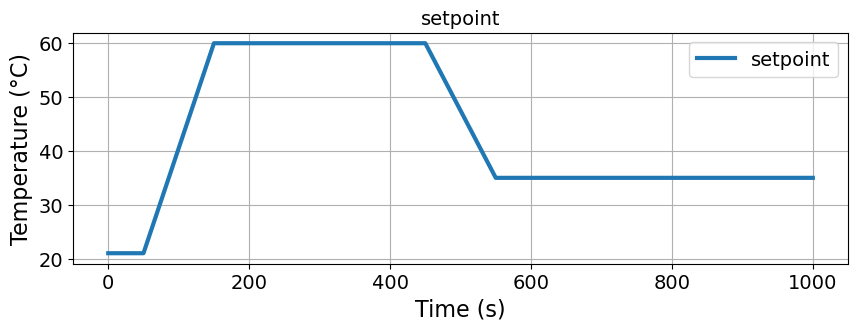

In [7]:
import numpy as np

# time grid
tf = 1000
dt = 2
n = round(tf / dt)
t_grid = np.linspace(0, 1000, n + 1)


# setpoint/reference
def r(t):
    return np.interp(t, [0, 50, 150, 450, 550], [Tamb_C, Tamb_C, 60, 60, 35])


# plot function
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t_grid, r(t_grid), label="setpoint")
ax.set_title('setpoint')
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('Time (s)')
ax.legend()
ax.grid(True)

Now let's solve the optimal control problem to find a control policy $u(t)$ for the interval $t_0 \leq t \leq t_f$ which causes the output $T_H(t)$ to track a desired setpoint or reference tracjectory $SP(t)$.

\begin{align*}
\min_{u(t)} ~~ & \int_{t_0}^{t_f} \|~SP(t) - T_H(t)~\|^2\,dt \\
\mathrm{s.t.}~~ & C_p^H \frac{dT_H}{dt} = U_a (T_{amb} - T_H) + U_b (T_S - T_H) + \alpha P u(t) \\
 & C_p^S \frac{dT_S}{dt} = - U_b (T_S - T_H) \\
 & T_H(t_0) = T_{amb} \\
 & T_S(t_0) = T_{amb}
\end{align*}

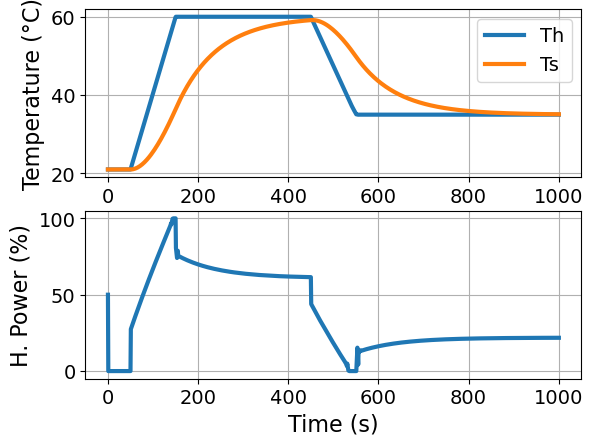

In [8]:
# Create a Pyomo model
m = pyo.ConcreteModel('TCLab Heater/Sensor')

# Define time domain
m.t = dae.ContinuousSet(bounds=(0, tf))

# Define the state variables as a function of time
m.Th = pyo.Var(m.t, units=units.kelvin)
m.Ts = pyo.Var(m.t, units=units.kelvin)

# Define the derivatives of the state variables
m.dTh = dae.DerivativeVar(m.Th)
m.dTs = dae.DerivativeVar(m.Ts)

# Define the control variable (heater power) as a function of time
m.u = pyo.Var(m.t, bounds=(0, 100))


# Define the integral of the squared error
@m.Integral(m.t)
def ise(m, t):
    return (units.convert_temp_C_to_K(r(t)) 
            - m.Th[t]) ** 2


# Define the first differential equation
@m.Constraint(m.t)
def heater1(m, t):
    return (
        CpH * m.dTh[t]
        == Ua * (Tamb - m.Th[t]) + Ub * (m.Ts[t] - m.Th[t]) + alpha * P * m.u[t]
    )


# Define the second differential equation
@m.Constraint(m.t)
def sensor1(m, t):
    return CpS * m.dTs[t] == Ub * (m.Th[t] - m.Ts[t])


# Fix the initial conditions
m.Th[0].fix(Tamb)
m.Ts[0].fix(Tamb)


# Define the objective function
@m.Objective(sense=pyo.minimize)
def objective(m):
    return m.ise


# Apply a collocation method to numerically integrate the differential equations
pyo.TransformationFactory('dae.collocation').apply_to(m, nfe=200, wrt=m.t)

# Call our nonlinear optimization/equation solver, Ipopt
pyo.SolverFactory('ipopt').solve(m)

plot_results(m)

## Take Away Messages

1. Pyomo is a great environment to formulate and solve optimization problems.
2. Predictive models are critical for intelligent decision making.
